# Topic Modeling of New York Times Articles

In [1]:
import pandas as pd
import numpy as np
import pre_processing as pp
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim

In [2]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/jmrt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jmrt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Pre-processing: Cleaning and tokenization of articles

In [3]:
files = ['data/ArticlesApril2018.csv', 'data/ArticlesFeb2018.csv', 
         'data/ArticlesJan2018.csv', 'data/ArticlesMarch2018.csv']

columns = ['articleID', 'articleWordCount', 'headline',
           'keywords', 'newDesk', 'snippet', 'typeOfMaterial']

def open_files(files, cols=None):
    '''
    Takes a list of file names and columns (optional) 
    and returns a pandas dataframe
    '''
    
    articles = []
    for filename in files:
        article = pd.read_csv(filename, usecols=cols)
        articles.append(article)
        
    return pd.concat(articles)
        
articles = open_files(files, columns)

In [315]:
def keys_snippet(row):
    if row['keywords'] != '[]':
        text = row['keywords'] + ' '+ row['headline']
    else:
        text = row['snippet']
    
    clean_text = pp.clean_text(text,stopwords=True,
                               add_sw=['j', 'iii', 'inc','ny', 'us','news',
                                       'un','donald', 'jr','al', 'e', 'unknown'])
    return clean_text

articles['pre_clean'] = articles.apply(lambda x: keys_snippet(x), axis=1) 

articles[['keywords', 'snippet', 'pre_clean']].head(10)

,keywords,snippet,pre_clean
0,"['Workplace Hazards and Violations', 'Football...","“I understand that they could meet with us, pa...",workplace hazards violations football cheerlea...
1,"['Environmental Protection Agency', 'Pruitt, S...",The agency plans to publish a new regulation T...,environmental protection agency pruitt scott u...
2,"['Restaurants', 'Noma (Copenhagen, Restaurant)...",What’s it like to eat at the second incarnatio...,restaurants noma copenhagen restaurant redzepi...
3,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",President Trump welcomed President Emmanuel Ma...,macron emmanuel trump white house building was...
4,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...","Alek Minassian, 25, a resident of Toronto’s Ri...",toronto ontario attack april murders attempted...
5,"['United States Politics and Government', 'Vet...",The Senate Veterans Affairs Committee is exami...,united states politics government veterans app...
6,[],Tuesday: Rent control appears headed to the ba...,tuesday rent control appears headed ballot que...
7,"['Presidential Election of 2016', 'Proceedings...","A new study suggests that the white, Christian...",presidential election proceedings national aca...
8,"['Texas', 'Soil', 'Pregnancy and Childbirth', ...",What can you do when you want your child to be...,texas soil pregnancy childbirth new york times...
9,[],Are you encouraged to question and articulate ...,encouraged question articulate queer devotions...


### 1.1 Get the bi-grams and tokenize each article

With bi-grams, we refer to words that go together, like United States or San Francisco. Using the `gensim.models.Phrases` method, we get this "bigrams" as: "united_states", "san_francisco".

Then we could also filter the documents by only taking the nouns of the documents and leaving out verbs.

And finally, we can convert each document in a list of words (tokens).

In [316]:
pre_process_docs = pp.bi_gram(articles.pre_clean, min_count=15, threshold=50) #Bi-grams

In [317]:
pre_process_docs[0]

'workplace_hazards violations football cheerleaders discrimination sexual_harassment national football league davis bailey goodell roger former n f l cheerleaders settlement offer meeting goodell'

#### 1.12 Lemmatization

**NOT IMPLEMENTED**

In [158]:
#import sys
#!{sys.executable} -m pip install -U spacy
#!{sys.executable} -m pip install spacy download en_core_web_sm import spacy
nlp = spacy.load('en_core_web_sm')

In [151]:
#Example of Lemmatizer
text1 = "I am eating after reading the news about Trump in United_states"
print('word, lemma, POS tag')
for token in nlp(text1):
    print(token.text, token.lemma_, token.pos_)

word, lemma, POS tag
I -PRON- PRON
am be AUX
eating eat VERB
after after ADP
reading read VERB
the the DET
news news NOUN
about about ADP
Trump Trump PROPN
in in ADP
United_states united_state NOUN


In [159]:
def apply_lem(text, only_nouns=False): 
    '''Lemmatize and limit words with length greater than 3 '''
    if only_nouns:
        text_lemmatized = []
        for token in nlp(text):
            if (token.pos_ == 'NOUN' or token.pos_ == 'INTJ' or token.pos_=='PROPN') \
            and len(token.text) > 3:
                text_lemmatized.append(token.lemma_)
    else:
        text_lemmatized = [token.lemma_ for token in nlp(text) \
                           if len(token.text) > 3]
    
    return text_lemmatized

### 1.13 Tokenize

In [318]:
docs = [word_tokenize(doc) for doc in pre_process_docs] #Tokenize
print(docs[500])

['trump', 'midterm_elections', 'impeachment', 'elections', 'house_representatives', 'republican_party', 'democratic_party', 'cruz', 'ted', 'stivers', 'steven', 'g_p', 'threat', 'impeachment', 'may', 'spur', 'voters']


## 2. Topic Modeling with LDA

In [319]:
# Create a dictionary representation of the documents. 
dictionary = gensim.corpora.Dictionary(docs) 
print('Number of unique tokens: %d' % len(dictionary))

# Filter out words that occur more than 50% of the documents.
#dictionary.filter_extremes(no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

#print('Number of unique tokens after filtering: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 13329
Number of documents: 4769


In [328]:
 #LdaMulticore uses all CPU cores to parallelize and speed up model training.
lda_model = gensim.models.LdaMulticore(corpus, num_topics = 15,
                                       id2word = dictionary, passes = 30,
                                       workers = 3, random_state=0)

In [349]:
topics=['NYC', 'Culture/Education', 'Leisure', 'International',
        'International', 'Culture/Education', 'Elections','Gun Crimes','Social Issues',
        'Entertainment', 'Social Media', 'Politics',
        'Leisure', 'Art', 'Culture/Education']

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}, {} \nWords: {}'.format(idx+1, topics[idx],topic))
    print('')

Topic: 1, NYC 
Words: 0.051*"new_york" + 0.044*"city" + 0.012*"theater" + 0.008*"authority" + 0.008*"syria" + 0.007*"music" + 0.007*"play" + 0.007*"nyc" + 0.007*"subways" + 0.006*"cuomo_andrew"

Topic: 2, Culture/Education 
Words: 0.023*"new_york" + 0.019*"times" + 0.010*"new" + 0.008*"education_k" + 0.007*"italy" + 0.007*"photography" + 0.006*"city" + 0.006*"media" + 0.006*"puerto_rico" + 0.006*"skills_education"

Topic: 3, Leisure 
Words: 0.048*"real_estate" + 0.040*"housing_residential" + 0.020*"brooklyn" + 0.018*"manhattan" + 0.015*"tv_program" + 0.012*"television" + 0.008*"season_episode" + 0.007*"weight" + 0.007*"east" + 0.007*"nyc"

Topic: 4, International 
Words: 0.016*"north_korea" + 0.014*"south_korea" + 0.012*"states" + 0.011*"united" + 0.011*"international_relations" + 0.010*"kim_jong" + 0.010*"olympic_games" + 0.008*"trump" + 0.008*"israel" + 0.007*"nuclear_weapons"

Topic: 5, International 
Words: 0.066*"united" + 0.064*"states" + 0.049*"trump" + 0.041*"government" + 0.04

### 2.2 LDA Model Results: Topics Visualization

In [350]:
#For each documents, get the one topic which dominates the most

def dominant_per_document(ldamodel, corpus, texts):
    '''
    Get top topic per document
    '''
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution',
                              'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    
    sent_topics_df['text'] = contents
    
    return sent_topics_df

In [351]:
#dominant_topics = dominant_per_document(ldamodel=lda_model,
#                                        corpus=corpus,
#                                        texts=pre_process_docs)
dominant_topics['topic_name'] = dominant_topics['Dominant_Topic'].apply(lambda x: topics[int(x)])
dominant_topics

,Dominant_Topic,Perc_Contribution,Topic_Keywords,text,topic_name
0,14.0,0.7858,"book, books_literature, metoo_movement, sexual...",workplace_hazards violations football cheerlea...,Culture/Education
1,6.0,0.6953,"trump, government, politics, states, united, a...",environmental_protection agency pruitt_scott u...,Elections
2,4.0,0.7529,"united, states, trump, government, politics, i...",restaurants noma copenhagen restaurant redzepi...,International
3,4.0,0.9594,"united, states, trump, government, politics, i...",macron_emmanuel trump white_house building was...,International
4,7.0,0.8963,"parkland_fla, gun_control, shooting, school_sh...",toronto_ontario attack april murders_attempted...,Gun Crimes
...,...,...,...,...,...
4764,11.0,0.4464,"states, united, trump, politics, government, i...",agriculture_farming international_trade world_...,Politics
4765,1.0,0.6013,"new_york, times, new, education_k, italy, phot...",blacks parenting careers professions new black...,Culture/Education
4766,1.0,0.9066,"new_york, times, new, education_k, italy, phot...",photography new_york times mattis james n subj...,Culture/Education
4767,10.0,0.5703,"government, politics, trump, states, facebook,...",privacy social_media united states politics go...,Social Media


In [352]:
topic_weights = [dict(lda_model[x]) for x in corpus]
topic_weights = pd.DataFrame(topic_weights)
print("Topic Weights per Document")
topic_weights

Topic Weights per Document


,5,14,6,8,4,12,7,13,1,3,0,2,9,10,11
0,0.176534,0.785757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.695234,0.253749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0.752950,0.174749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.959407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.896286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,NaN,NaN,NaN,NaN,0.179287,NaN,0.135670,NaN,NaN,0.210543,NaN,NaN,NaN,NaN,0.446274
4765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.302305,0.601381,NaN,NaN,NaN,NaN,NaN,NaN
4766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.906649,NaN,NaN,NaN,NaN,NaN,NaN
4767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.570259,0.375567


In [362]:
#Obtain the mean weight contribution of each topic and the count
stats = []
for col in topic_weights:
    d = {}
    d['mean_weight'] = topic_weights[col].mean()
    d['count'] = topic_weights[col].count()
    d['topic'] = col
    stats.append(d)

stats = pd.DataFrame(stats)
#Aggregate and merge all results
topic_counts = dominant_topics.groupby('Dominant_Topic').size().reset_index(name='dominant_count')

topic_counts = topic_counts.sort_values(by='dominant_count', ascending=False)
topic_counts = topic_counts.merge(stats, left_on='Dominant_Topic',
                                  right_on='topic').drop(columns='Dominant_Topic')

topic_counts.sort_values(by='topic', inplace=True)
topic_counts.reset_index(drop=True, inplace=True)

topic_counts['topic_name'] = topic_counts.apply(lambda x: topics[int(x['topic'])],
                                                axis=1)

wm = lambda x: np.average(x, weights=topic_counts.loc[x.index, "dominant_count"])

tc = topic_counts.groupby('topic_name').agg(mean_weight = ('mean_weight', wm)).reset_index()
tc2 = topic_counts.groupby('topic_name').agg(dominant_count = ('dominant_count', 'sum')).reset_index()

topic_counts = tc.merge(tc2)
topic_counts

,topic_name,mean_weight,dominant_count
0,Art,0.271688,210
1,Culture/Education,0.298475,803
2,Elections,0.333752,375
3,Entertainment,0.359777,333
4,Gun Crimes,0.307085,329
5,International,0.339463,815
6,Leisure,0.294539,521
7,NYC,0.325590,293
8,Politics,0.379143,522
9,Social Issues,0.281703,241


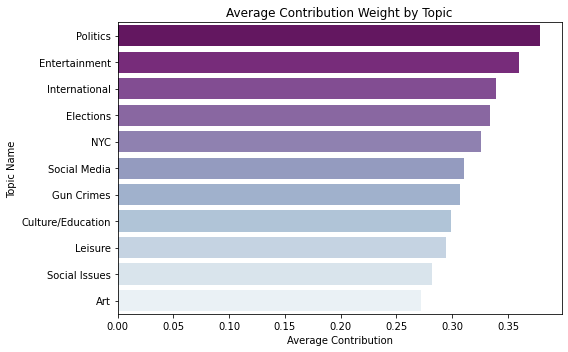

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
#topic_counts.sort_values(by='count', ascending=False, inplace=True)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(y="topic_name", x="mean_weight", 
            data=topic_counts.sort_values(by='mean_weight', 
                                          ascending=False),
            ax=ax1, palette='BuPu_r')
ax1.set_title('Average Contribution Weight by Topic', 
              fontdict=dict(size=12))
ax1.set_xlabel('Average Contribution')
ax1.set_ylabel('Topic Name')
fig.tight_layout();

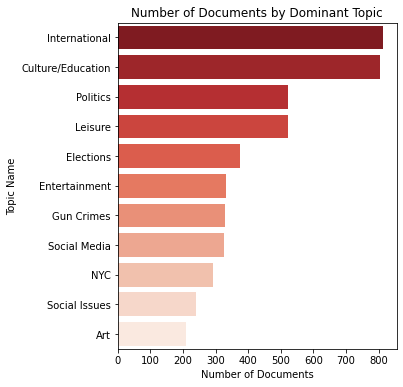

In [364]:
fig, ax1 = plt.subplots(figsize=(5, 6))
sns.barplot(y="topic_name", x="dominant_count",
data=topic_counts.sort_values(by='dominant_count',
                              ascending=False), 
            ax=ax1, palette='Reds_r')
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=12))
ax1.set_xlabel('Number of Documents')
ax1.set_ylabel('Topic Name');

In [365]:
articles['topic'] = dominant_topics['Dominant_Topic'].apply(lambda x: topics[int(x)])

In [366]:
articles[['articleID','topic', 'headline']]

,articleID,topic,headline
0,5adf6684068401528a2aa69b,Culture/Education,Former N.F.L. Cheerleaders’ Settlement Offer: ...
1,5adf653f068401528a2aa697,Elections,E.P.A. to Unveil a New Rule. Its Effect: Less ...
2,5adf4626068401528a2aa628,International,"The New Noma, Explained"
3,5adf40d2068401528a2aa619,International,Unknown
4,5adf3d64068401528a2aa60f,Gun Crimes,Unknown
...,...,...,...
1380,5ac1647647de81a90121adaa,Gun Crimes,Will Trump Start a Farm Crisis?
1381,5ac1654f47de81a90121adb2,Culture/Education,A New Black American Dream
1382,5ac1700447de81a90121ade2,Social Issues,When a Subject Refuses to Pose
1383,5ac1720c47de81a90121adf0,Leisure,America Needs Better Privacy Rules


In [367]:
articles[['articleID','topic', 'headline']].to_csv('data/articles.csv')

## 3. FastText Word embeddings

In [264]:
from gensim.models.fasttext import FastText
from gensim.models.fasttext import load_facebook_model

### 3.1 Download pre-trained word-embeddings and re-train with New York Times articles

In [265]:
#Takes some time
wordvectors_file = '../cc.en.300.bin'
wordvectors = load_facebook_model(wordvectors_file)

In [266]:
wordvectors.build_vocab(docs, update=True) # Update the vocabulary 
wordvectors.train(docs,total_examples=len(docs), 
                  epochs=2, min_count=50) #train

In [267]:
len(wordvectors.wv.vocab)

2000300

In [268]:
print(wordvectors.wv.most_similar_cosmul(positive=['obama']))

[('obamas', 0.9300481677055359), ('nobama', 0.908802330493927), ('obummer', 0.8968707919120789), ('obama.', 0.8944075703620911), ('obozo', 0.8920220732688904), ('barack', 0.8879040479660034), ('clinton', 0.8860569596290588), ('mccain', 0.8846276998519897), ('romney', 0.882229208946228), ('gop', 0.8799362778663635)]


### 3.2 Compute the average vector of the word-embeddings in each article

In [368]:
doc_vecs = [] 
processed_docs = []

for token_words in docs:
    if not token_words:
        continue
    document_word_vectors=[]
    for word in token_words:
        if word in wordvectors.wv:
            document_word_vectors.append(wordvectors.wv[word])
    
    document_vector = np.mean(document_word_vectors, axis=0)
    doc_vecs.append(document_vector)
    
    processed_docs.append(" ".join(token_words))

In [369]:
len(doc_vecs) #Number of articles of the New York Times database

4769

### 3.3 Clustering the documents with KMeans 

By clustering the documents in groups (topics), we can estimate the main topics (clusters) of the data and get the relevant words of each cluster. With this, we will infer about the topic discussed

In [ ]:
from nltk.cluster import KMeansClusterer

num_clusters = 12 #MAIN topics
kclusterer = KMeansClusterer(num_clusters, 
                             distance=nltk.cluster.util.cosine_distance, 
                             repeats=25)

assigned_clusters = kclusterer.cluster(np.array(doc_vecs), 
                                       assign_clusters=True)

In [286]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_df=0.85,
                   stop_words=nltk.corpus.stopwords.words('english'),
                   min_df=3)

word_count_vector=cv.fit_transform(processed_docs)

In [287]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)

tfidf_transformer.fit(word_count_vector)

feature_names=cv.get_feature_names()

In [288]:
cluster_keywords={}
for i in range(num_clusters):
    docs =' '.join(np.array(processed_docs)[np.array(assigned_clusters)==i])
    
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs]))
    
    #sort the tf-idf vectors by descending order of scores
    matrix=tf_idf_vector.tocoo()
    tuples=zip(matrix.col, matrix.data)
    sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
    
    #extract only the top n
    n=10
    sorted_items = sorted_items[:n]
    
    keywords = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        #keep track of feature name
        keywords.append(feature_names[idx])
    
    cluster_keywords[i] = keywords

In [289]:
topics_kmeans=['Food', 'International Relations', 'Real Estate', 'International Relations'
              'Health', 'w', 'w', 'd', 'q', 'qwe', 'qweqwe', 'qwe']
for cluster, words in cluster_keywords.items():
    print('')
    print('Cluster {}: {}'.format(cluster, topics_kmeans[cluster]))
    print("{}".format(words))


Cluster 0: Food
['city', 'new_york', 'subways', 'authority', 'housing_residential', 'real_estate', 'buses', 'transit', 'metropolitan_transportation', 'dogs']

Cluster 1: International Relations
['image', 'think', 'see', 'look_closely', 'join_moderated', 'conversation_students', 'would', 'stripped', 'caption', 'best']

Cluster 2: Real Estate
['cooking_cookbooks', 'cancer', 'food', 'diet_nutrition', 'weight', 'heart', 'obesity', 'exercise', 'medical', 'parenting']

Cluster 3: International RelationsHealth
['united_states', 'politics_government', 'trump', 'international_relations', 'new_york', 'forces', 'republican_party', 'international_trade', 'defense_military', 'world_market']

Cluster 4: w
['art', 'music', 'movie', 'book', 'television', 'museum', 'movies', 'tv_program', 'photography', 'museums']

Cluster 5: w
['united_states', 'trump', 'politics_government', 'trump_associates', 'russian_interference', 'elections_ties', 'russia', 'putin_vladimir', 'international_relations', 'investig

### 3.3 Using TSNE to visualize the documents

Using TSNE, we can visualize the documents with 2 dimensions (right now each document has 300 dimensions (the length of the vector)). Then we can color each document by the cluster/topic in which they belong to. 

In [280]:
from sklearn.manifold import TSNE

In [281]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, 
                  angle=.99, init='pca', perplexity=30)
tsne_results = tsne_model.fit_transform(np.array(doc_vecs))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4769 samples in 0.063s...
[t-SNE] Computed neighbors for 4769 samples in 12.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4769
[t-SNE] Computed conditional probabilities for sample 2000 / 4769
[t-SNE] Computed conditional probabilities for sample 3000 / 4769
[t-SNE] Computed conditional probabilities for sample 4000 / 4769
[t-SNE] Computed conditional probabilities for sample 4769 / 4769
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.639885
[t-SNE] KL divergence after 1000 iterations: 1.825241


Cluster 1: ['cooking_cookbooks', 'recipes', 'ice', 'wines', 'vegetables', 'products', 'crossword_puzzles', 'hockey', 'bakeries', 'baked']
Cluster 2: ['bush_george', 'united_states', 'trump', 'tillerson_rex', 'politics_government', 'international_relations', 'state', 'department', 'iraq', 'pompeo_mike']
Cluster 3: ['city', 'new_york', 'subways', 'housing_residential', 'real_estate', 'buses', 'dogs', 'authority', 'birthdays', 'suburbs']
Cluster 4: ['syria', 'forces', 'defense_military', 'united_states', 'israel', 'international_relations', 'germany', 'italy', 'iraq_syria', 'politics_government']
Cluster 5: ['image', 'think', 'see', 'look_closely', 'join_moderated', 'conversation_students', 'would', 'stripped', 'caption', 'best']
Cluster 6: ['united_states', 'trump', 'politics_government', 'international_relations', 'republican_party', 'crossword_puzzles', 'international_trade', 'world_market', 'democratic_party', 'senate']
Cluster 7: ['cancer', 'weight', 'exercise', 'obesity', 'families_

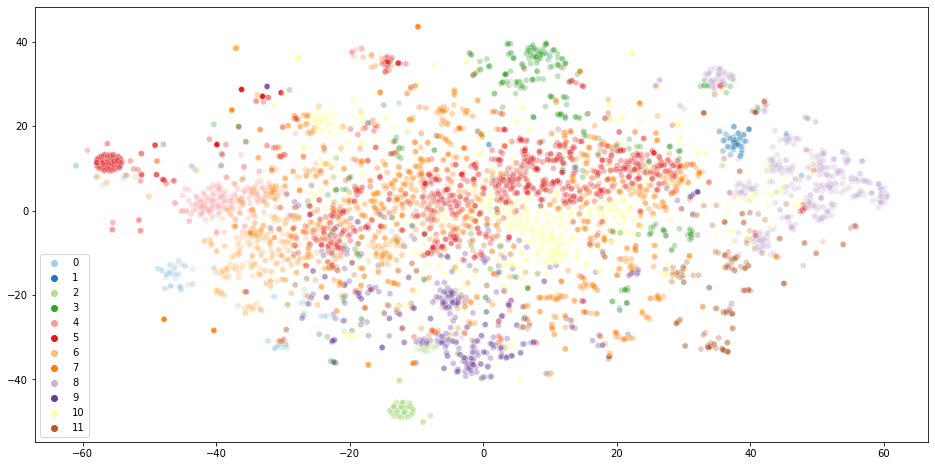

In [282]:
fig, ax1 = plt.subplots(figsize=(16, 8))
for i in range(num_clusters):
    print('Cluster {}: {}'.format(i+1, cluster_keywords[i]))

sns.scatterplot(x=tsne_results[:,0], 
                    y=tsne_results[:,1], 
                    hue=assigned_clusters, 
                palette=sns.color_palette("Paired", num_clusters),
                legend="full",
                alpha=0.3, ax=ax1);